# Step 1 - Model Training

Now that we have a feel for the data we are dealing with, we can start designing our model. In this notebook, we will define the network architecture and train the model. We will also discuss some of the transformations on the data in response to observations that we made in the data exploration section of the notebook.

Let us start by importing some libraries and defining some paths.

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
import keras.backend as K
from keras.preprocessing import image

from keras_tqdm import TQDMNotebookCallback

import json
import os
import numpy as np
import pandas as pd
from Generator import DriveDataGenerator
from Cooking import checkAndCreateDir
import h5py
from PIL import Image, ImageDraw
import math
import matplotlib.pyplot as plt


BASE_PATH = 'C:\END_TO_END_DATA'

# << Point this to the desired output directory for the cooked (.h5) data >>
COOKED_DATA_DIR = os.path.join(BASE_PATH, 'data_cooked')

# << The directory in which the model output will be placed >>
MODEL_OUTPUT_DIR = os.path.join(BASE_PATH, 'model_Coastline2')
print(MODEL_OUTPUT_DIR)

Using TensorFlow backend.
C:\Users\deveu\.conda\envs\airsim\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\deveu\.conda\envs\airsim\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\deveu\.conda\envs\airsim\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\deveu\.conda\envs\airsim\lib\site-packages\t

C:\END_TO_END_DATA\model_Coastline2


Let's read in the datasets from the exploration phase. If these do not exist, run the snippet from the [previous](DataExplorationAndPreparation.ipynb) notebook to generate them.

In [2]:
train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')

num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]

batch_size=32

For image data, it is too expensive to load the entire dataset into memory. Fortunatly, Keras has the concept of DataGenerators. A DataGenerator is nothing more than an iterator that will read data from disk in chunks. This allows you to keep both your CPU and GPU busy, increasing throughput. 

We made a few observations during the exploration phase. Now let's come up with a strategy to incorporate them in our training algorithm:
* **Only a small portion of the image is of interest** - when generating batches, we can remove the pieces of the image that are not of interest.
* **The dataset exhibits vertical flip tolerance** - when generating batches, we can randomly flip some images and labels around the Y axis so the model has new data to learn from.
* **The dataset should be invariant to changes in lighting** - when generating batches, we can randomly add or remove brightness from the images so the model can learn that global changes in lighting should be ignored.
* **The dataset has a high proportion of zero-valued images** - when generating batches, we can randomly drop a percentage of data points where the steering angle is zero so the model sees a balanced dataset when training.
* **We need examples from the swerving strategy in our dataset so the model learns how to turn sharply** - we took care of this in the preprocessing phase.

While Keras does have some standard built-in transforms for images, they are not sufficient for our purpose. For example, when using horizontal_flip = True in the standard ImageDataGenerator, the signs of the labels are not inverted. Fortunatly, we can just extend the ImageDataGenerator class and implement our own transform logic. The code to do so is in Generator.py - it is straightforward, but too long to include in this notebook.

Here, we will initialize the generator with the following parameters:
* **Zero_Drop_Percentage: 0.9** - That is, we will randomly drop 90% of the data points with label = 0
* **Brighten_Range: 0.4** - That is, the brighness of each image will be modified by up to 40%. To compute "brightness", we transform the image from RGB to HSV space, scale the 'V' coordinate up or down, and transform back to RGB space.
* **ROI: [76,135,0,255]** - This is the x1, x2, y1, y2 rectangle that represents the area of interest for the images.

> **Thought Exercise 1.1**
Try playing around with these parameters to see if you can get better results.

In [3]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brighten_range=0.4)
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.90, roi=[76,135,0,255])
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.90, roi=[76,135,0,255])    

Let's look at a sample batch. The steering angle is represented by the red line in the image:

Actual Steering Angle = [-0.66666667]


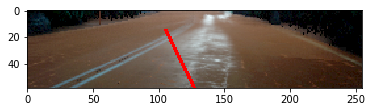

Actual Steering Angle = [1.]


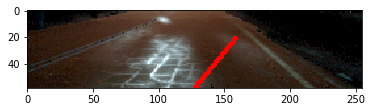

Actual Steering Angle = [-0.33333333]


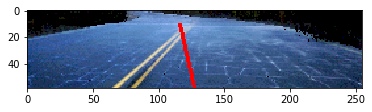

Actual Steering Angle = [0.33333333]


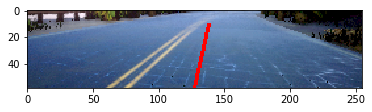

Actual Steering Angle = [-1.]


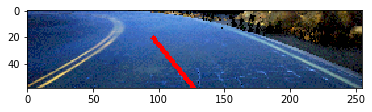

In [4]:
def draw_image_with_label(img, label, prediction=None):
    theta = label * 0.69 #Steering range for the car is +- 40 degrees -> 0.69 radians
#     theta = label
    line_length = 50
    line_thickness = 3
    label_line_color = (255, 0, 0) #red
    prediction_line_color = (0, 0, 255) #blue
    pil_image = image.array_to_img(img, K.image_data_format(), scale=True)
    print('Actual Steering Angle = {0}'.format(label))
    draw_image = pil_image.copy()
    image_draw = ImageDraw.Draw(draw_image)
    first_point = (int(img.shape[1]/2),img.shape[0])
    second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
    image_draw.line([first_point, second_point], fill=label_line_color, width=line_thickness)
    
    if (prediction is not None):
        print('Predicted Steering Angle = {0}'.format(prediction))
        print('L1 Error: {0}'.format(abs(prediction-label)))
        theta = prediction * 0.69
        second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
        image_draw.line([first_point, second_point], fill=prediction_line_color, width=line_thickness)
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()

[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
for i in range(0, 5, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i])

Next, let's define the network architecture. We will use a standard combination of convolutional / max pooling layers to process the images (we cannot go into the details of what each of these layers do here, but you should definitely check out the book mentioned in the readme file if you do not understand what is going on). Then, we will inject the vehicle's last known state into the dense layer as an additional feature. The layer sizes and optimization parameters were determined experimentally - try tweaking them and see what happens!

In [5]:
image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1, name='output')(merged)

adam = Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Let's look at a summary of our model

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 59, 255, 3)   0                                            
__________________________________________________________________________________________________
convolution0 (Conv2D)           (None, 59, 255, 16)  448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 29, 127, 16)  0           convolution0[0][0]               
__________________________________________________________________________________________________
convolution1 (Conv2D)           (None, 29, 127, 32)  4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

That's a lot of parameters! Fortunately, we have our data augmentation strategies, so the network has a chance of converging. Try adding / removing layers or changing their widths to see what effect it has on the number of trainable parameters in the network.

One of the nice features of Keras is the ability to declare callbacks. These functions get executed after each epoch of training. We will define a few callbacks:

* **ReduceLrOnPlateau** - If the model is near a minimum and the learning rate is too high, then the model will circle around that minimum without ever reaching it. This callback will allow us to reduce the learning rate when the validation loss stops improving, allowing us to reach the optimal point.
* **CsvLogger** - This lets us log the output of the model after each epoch, which will allow us to track the progress without needing to use the console.
* **ModelCheckpoint** - Generally, we will want to use the model that has the lowest loss on the validation set. This callback will save the model each time the validation loss improves.
* **EarlyStopping** - We will want to stop training when the validation loss stops improving. Otherwise, we risk overfitting. This monitor will detect when the validation loss stops improving, and will stop the training process when that occurs.

In [7]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, TQDMNotebookCallback()]

It's time to train the model! With the default setup, this model takes ~45 min to train on an NVidia GTX970 GPU. Note: sometimes the model will get stuck with a constant validation loss for up to 7 epochs. If left to run, the model should terminate with a validation loss of approximately .0003.

In [8]:
history = model.fit_generator(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=200, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2)

Epoch 1/200
Epoch 00001: val_loss improved from inf to 0.33261, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.01-0.3326146.h5
 - 12s - loss: 0.5230 - val_loss: 0.3326


Epoch 2/200
Epoch 00002: val_loss improved from 0.33261 to 0.18715, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.02-0.1871511.h5
 - 7s - loss: 0.3052 - val_loss: 0.1872


Epoch 3/200
Epoch 00003: val_loss improved from 0.18715 to 0.13889, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.03-0.1388865.h5
 - 7s - loss: 0.2179 - val_loss: 0.1389


Epoch 4/200
Epoch 00004: val_loss improved from 0.13889 to 0.11385, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.04-0.1138532.h5
 - 7s - loss: 0.1937 - val_loss: 0.1139


Epoch 5/200
Epoch 00005: val_loss did not improve
 - 7s - loss: 0.1673 - val_loss: 0.1214


Epoch 6/200
Epoch 00006: val_loss improved from 0.11385 to 0.09980, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.06-0.0997950.h5
 - 7s - loss: 0.1610 - val_loss: 0.0998


Epoch 7/200
Epoch 00007: val_loss improved from 0.09980 to 0.09795, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.07-0.0979462.h5
 - 7s - loss: 0.1491 - val_loss: 0.0979


Epoch 8/200
Epoch 00008: val_loss did not improve
 - 7s - loss: 0.1379 - val_loss: 0.0990


Epoch 9/200
Epoch 00009: val_loss improved from 0.09795 to 0.08557, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.09-0.0855679.h5
 - 7s - loss: 0.1326 - val_loss: 0.0856


Epoch 10/200
Epoch 00010: val_loss improved from 0.08557 to 0.08302, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.10-0.0830198.h5
 - 7s - loss: 0.1283 - val_loss: 0.0830


Epoch 11/200
Epoch 00011: val_loss improved from 0.08302 to 0.08115, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.11-0.0811517.h5
 - 7s - loss: 0.1238 - val_loss: 0.0812


Epoch 12/200
Epoch 00012: val_loss improved from 0.08115 to 0.07779, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.12-0.0777913.h5
 - 7s - loss: 0.1193 - val_loss: 0.0778


Epoch 13/200
Epoch 00013: val_loss did not improve
 - 7s - loss: 0.1139 - val_loss: 0.0788


Epoch 14/200
Epoch 00014: val_loss improved from 0.07779 to 0.07642, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.14-0.0764171.h5
 - 7s - loss: 0.1171 - val_loss: 0.0764


Epoch 15/200
Epoch 00015: val_loss did not improve
 - 7s - loss: 0.1126 - val_loss: 0.0771


Epoch 16/200
Epoch 00016: val_loss did not improve
 - 7s - loss: 0.1101 - val_loss: 0.0778


Epoch 17/200
Epoch 00017: val_loss improved from 0.07642 to 0.07429, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.17-0.0742912.h5
 - 7s - loss: 0.1071 - val_loss: 0.0743


Epoch 18/200
Epoch 00018: val_loss improved from 0.07429 to 0.07201, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.18-0.0720136.h5
 - 7s - loss: 0.1070 - val_loss: 0.0720


Epoch 19/200
Epoch 00019: val_loss did not improve
 - 7s - loss: 0.1037 - val_loss: 0.0748


Epoch 20/200
Epoch 00020: val_loss did not improve
 - 7s - loss: 0.1041 - val_loss: 0.0730


Epoch 21/200
Epoch 00021: val_loss did not improve
 - 7s - loss: 0.1016 - val_loss: 0.0731


Epoch 22/200
Epoch 00022: val_loss improved from 0.07201 to 0.07071, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.22-0.0707074.h5
 - 7s - loss: 0.1016 - val_loss: 0.0707


Epoch 23/200
Epoch 00023: val_loss did not improve
 - 7s - loss: 0.0997 - val_loss: 0.0729


Epoch 24/200
Epoch 00024: val_loss did not improve
 - 7s - loss: 0.0997 - val_loss: 0.0747


Epoch 25/200
Epoch 00025: val_loss did not improve
 - 7s - loss: 0.0960 - val_loss: 0.0725


Epoch 26/200
Epoch 00026: val_loss did not improve
 - 7s - loss: 0.0974 - val_loss: 0.0725


Epoch 27/200
Epoch 00027: val_loss did not improve
 - 7s - loss: 0.1004 - val_loss: 0.0709


Epoch 28/200
Epoch 00028: val_loss did not improve
 - 7s - loss: 0.0997 - val_loss: 0.0751


Epoch 29/200
Epoch 00029: val_loss did not improve
 - 7s - loss: 0.0937 - val_loss: 0.0723


Epoch 30/200
Epoch 00030: val_loss did not improve
 - 7s - loss: 0.0955 - val_loss: 0.0724


Epoch 31/200
Epoch 00031: val_loss did not improve
 - 7s - loss: 0.0929 - val_loss: 0.0725


Epoch 32/200
Epoch 00032: val_loss improved from 0.07071 to 0.07050, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.32-0.0705041.h5
 - 7s - loss: 0.0883 - val_loss: 0.0705


Epoch 33/200
Epoch 00033: val_loss did not improve
 - 7s - loss: 0.0890 - val_loss: 0.0711


Epoch 34/200
Epoch 00034: val_loss did not improve
 - 7s - loss: 0.0895 - val_loss: 0.0739


Epoch 35/200
Epoch 00035: val_loss did not improve
 - 7s - loss: 0.0890 - val_loss: 0.0709


Epoch 36/200
Epoch 00036: val_loss did not improve
 - 7s - loss: 0.0884 - val_loss: 0.0711


Epoch 37/200
Epoch 00037: val_loss improved from 0.07050 to 0.06977, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.37-0.0697655.h5
 - 7s - loss: 0.0878 - val_loss: 0.0698


Epoch 38/200
Epoch 00038: val_loss did not improve
 - 7s - loss: 0.0852 - val_loss: 0.0711


Epoch 39/200
Epoch 00039: val_loss improved from 0.06977 to 0.06710, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.39-0.0671047.h5
 - 7s - loss: 0.0862 - val_loss: 0.0671


Epoch 40/200
Epoch 00040: val_loss did not improve
 - 7s - loss: 0.0845 - val_loss: 0.0719


Epoch 41/200
Epoch 00041: val_loss improved from 0.06710 to 0.06596, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.41-0.0659601.h5
 - 7s - loss: 0.0873 - val_loss: 0.0660


Epoch 42/200
Epoch 00042: val_loss did not improve
 - 7s - loss: 0.0861 - val_loss: 0.0668


Epoch 43/200
Epoch 00043: val_loss improved from 0.06596 to 0.06588, saving model to C:\END_TO_END_DATA\model_Coastline2\models\model_model.43-0.0658770.h5
 - 7s - loss: 0.0848 - val_loss: 0.0659


Epoch 44/200
Epoch 00044: val_loss did not improve
 - 7s - loss: 0.0826 - val_loss: 0.0716


Epoch 45/200
Epoch 00045: val_loss did not improve
 - 7s - loss: 0.0842 - val_loss: 0.0673


Epoch 46/200
Epoch 00046: val_loss did not improve
 - 7s - loss: 0.0828 - val_loss: 0.0695


Epoch 47/200
Epoch 00047: val_loss did not improve
 - 7s - loss: 0.0808 - val_loss: 0.0673


Epoch 48/200
Epoch 00048: val_loss did not improve
 - 7s - loss: 0.0828 - val_loss: 0.0681


Epoch 49/200
Epoch 00049: val_loss did not improve
 - 7s - loss: 0.0809 - val_loss: 0.0698


Epoch 50/200
Epoch 00050: val_loss did not improve
 - 7s - loss: 0.0806 - val_loss: 0.0692


Epoch 51/200
Epoch 00051: val_loss did not improve
 - 7s - loss: 0.0792 - val_loss: 0.0691


Epoch 52/200
Epoch 00052: val_loss did not improve
 - 7s - loss: 0.0775 - val_loss: 0.0709


Epoch 53/200
Epoch 00053: val_loss did not improve
 - 7s - loss: 0.0765 - val_loss: 0.0666
Epoch 00053: early stopping



Let's do a quick sanity check. We'll load a few training images and compare the labels and the predictions. These should be very close in value if our model has learned properly.

Actual Steering Angle = [-0.33333333]
Predicted Steering Angle = [-0.29382426]
L1 Error: [0.03950908]


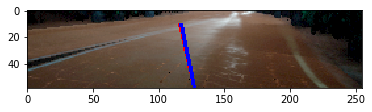

Actual Steering Angle = [-0.66666667]
Predicted Steering Angle = [-0.7110129]
L1 Error: [0.04434623]


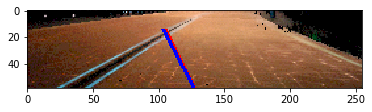

Actual Steering Angle = [-0.66666667]
Predicted Steering Angle = [-0.8078836]
L1 Error: [0.14121695]


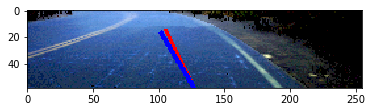

Actual Steering Angle = [0.33333333]
Predicted Steering Angle = [0.49260718]
L1 Error: [0.15927384]


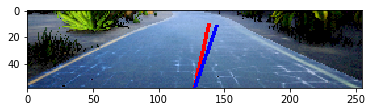

Actual Steering Angle = [0.66666667]
Predicted Steering Angle = [0.4651913]
L1 Error: [0.20147536]


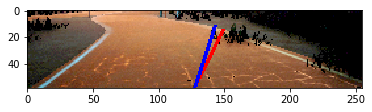

In [10]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(0, 5, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i], predictions[i])

Looks good! Let's move on to actually running the model with AirSim in the [next notebook](TestModel.ipynb).